In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [2]:
#load signal, backgound data
vbf_events = pd.read_hdf("../MC_Prod_v12/vbf_events.hdf", "vbf") #do hdf5!!
ggf_events = pd.read_hdf("../MC_Prod_v12/ggF_events.hdf", "ggF")
qq_events = pd.read_hdf("../MC_Prod_v12/qq_all_events.hdf", "qq_all")

In [3]:
vbf_events["class"] = 1
ggf_events["class"] = 0#2 # need to reweight ggF better! set to 0 afterwards
qq_events["class"] = 0

In [4]:
vbf_events.weight_couplings.sum(), ggf_events.weight_couplings.sum(), qq_events.weight_couplings.sum()

(6.0885523004705586, 8.7771621167023159, 60.047187373963304)

In [5]:
#ggf_events_train.weight_couplings *= ggf_events_train.weight_couplings.sum()

In [6]:
data = pd.concat([vbf_events, ggf_events, qq_events])
#print data.isnull().values.any()
#data.describe()
data = data.sample(frac=1).reset_index(drop=True) #shuffle the events
target = data["class"]
mass = data["m4l_fsr"]
weights = data["weight_couplings"]
del data["class"]
del data["m4l_fsr"]
del data["weight_couplings"]

In [7]:
mass = mass.apply(np.log)
mass_max, mass_min = mass.max(), mass.min()
mass = (mass - mass_min)/(mass_max - mass_min) #!!! save max, min values to file
#mass.describe()
#plt.hist(mass)
#plt.show()

In [8]:
data.head(5)

,dijet_invmass,dijet_deltaeta,eta_zepp_ZZ,min_dR_jZ,leading_jet_width,subleading_jet_width,jet_pt[0],jet_pt[1],"max(50,pt4ljj_unconstrained)"
0,1415.766846,3.142791,0.386907,2.841227,0.098354,0.060970,394.519806,211.923706,75.842102
1,410.642029,1.398824,1.373676,0.815706,0.036666,0.048841,212.632095,130.959991,50.000000
2,284.576965,1.954499,1.216749,1.126583,0.042630,0.076716,129.054047,68.180885,50.000000
3,897.100220,3.945160,0.037694,0.706447,0.057253,0.068169,125.921494,118.963982,50.000000
4,146.191177,2.991696,2.342637,1.087454,0.112576,0.154861,31.432322,30.712952,50.000000


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test, mass_train, mass_test, weights_train, weights_test = \
    train_test_split(data, target, mass, weights, train_size=0.75)
#reset index for dataseries, not needed for ndarray (X_train, X_test)
y_train, y_test, mass_train, mass_test, weights_train, weights_test = \
 y_train.reset_index(drop=True),y_test.reset_index(drop=True), \
    mass_train.reset_index(drop=True), mass_test.reset_index(drop=True), \
    weights_train.reset_index(drop=True), weights_test.reset_index(drop=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/usr/local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [10]:
import keras.backend as K
from keras.layers import Input, Dense
from keras.models import Model


#@TODO: check other activations in Andreas, Gilles pivot
inputs = Input(shape=(X_train.shape[1],))
Dx = Dense(32, activation="relu")(inputs)
Dx = Dense(32, activation="relu")(Dx)
Dx = Dense(32, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(input=[inputs], output=[Dx])
D.compile(loss="binary_crossentropy", optimizer="adam")

Using TensorFlow backend.
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`
  if sys.path[0] == '':


In [ ]:
#weights_train.isnull().any()

In [ ]:
#weights_train *=1000000

In [ ]:
#weights_train.describe()

In [ ]:
#(weights_train ==0).any()

In [11]:
def get_class_weights(y, smooth_factor=0):
    """
    Returns the weights for each class based on the frequencies of the samples
    :param smooth_factor: factor that smooths extremely uneven weights
    :param y: list of true labels (the labels must be hashable)
    :return: dictionary with the weight for each class
    """
    from collections import Counter
    counter = Counter(y)

    if smooth_factor > 0:
        p = max(counter.values()) * smooth_factor
        for k in counter.keys():
            counter[k] += p

    majority = max(counter.values())

    return {cls: float(majority) / count for cls, count in counter.items()}

In [12]:
#D.fit(X_train, y_train, sample_weight=weights_train, nb_epoch=10) #nan loss
#D.fit(X_train, y_train, nb_epoch=10) #unweighted training !!! @TODO: weighted
D.fit(X_train, y_train, nb_epoch=10, class_weight=get_class_weights(y_train)) #unweighted training !!! @TODO: weighted

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/10
167568/167568 [==============================] - 12s - loss: 0.5783    
Epoch 2/10
167568/167568 [==============================] - 11s - loss: 0.5651    
Epoch 3/10
167568/167568 [==============================] - 11s - loss: 0.5619    
Epoch 4/10
167568/167568 [==============================] - 11s - loss: 0.5599    
Epoch 5/10
167568/167568 [==============================] - 11s - loss: 0.5590    
Epoch 6/10
167568/167568 [==============================] - 11s - loss: 0.5581    
Epoch 7/10
167568/167568 [==============================] - 11s - loss: 0.5573    
Epoch 8/10
167568/167568 [==============================] - 11s - loss: 0.5567    
Epoch 9/10
167568/167568 [==============================] - 11s - loss: 0.5562    
Epoch 10/10
167568/167568 [==============================] - 11s - loss: 0.5560    


In [13]:
get_class_weights(y_train)

{0: 1.0, 1: 1.6914662940297789}

In [14]:
len(vbf_events), len(ggf_events), len(qq_events)

(83085, 13069, 127270)

In [15]:
from sklearn.metrics import roc_auc_score
y_pred = D.predict(X_test)
y_pred = y_pred.ravel()
roc_auc_score(y_true=y_test, y_score=y_pred, sample_weight=weights_test)
#roc_auc_score(y_true=y_test, y_score=y_pred)

0.87717017411350584

In [16]:
mass_test.describe()

count    55856.000000
mean         0.175398
std          0.132836
min          0.000007
25%          0.073535
50%          0.148376
75%          0.246128
max          0.971609
Name: m4l_fsr, dtype: float64

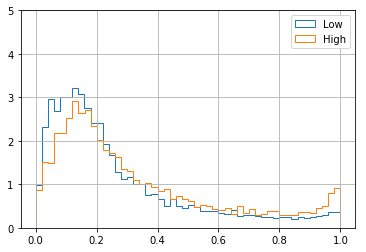

In [17]:
plt.hist(y_pred[mass_test<mass_test.mean()], weights=weights_test[mass_test<mass_test.mean()], bins=50, histtype="step", normed=1, label="Low")
plt.hist(y_pred[mass_test>=mass_test.mean()], weights=weights_test[mass_test>=mass_test.mean()], bins=50, histtype="step", normed=1, label="High")
#plt.hist(y_pred[mass_test<mass.mean()], bins=50, histtype="step", normed=1, label="Low")
#plt.hist(y_pred[mass_test>=mass.mean()], bins=50, histtype="step", normed=1, label="High")


plt.ylim(0, 5)
plt.legend()
plt.grid()
plt.show()# @TODO: do sep for signal background, plot mass : full mass dist, vs after cut on bdt

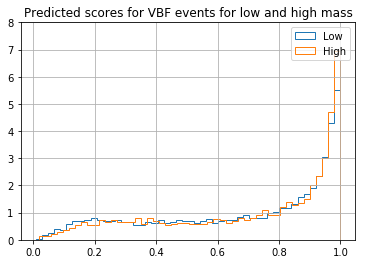

In [18]:
signal_low = list (set( np.where(y_test==1)[0] ) & set( np.where(mass_test<mass_test.mean())[0]))
signal_high = list (set( np.where(y_test==1)[0] ) & set( np.where(mass_test>=mass_test.mean())[0]))

plt.hist(y_pred[signal_low], weights=weights_test[signal_low], bins=50, histtype="step", normed=1, label="Low")
plt.hist(y_pred[signal_high], weights=weights_test[signal_high], bins=50, histtype="step", normed=1, label="High")

plt.title("Predicted scores for VBF events for low and high mass")
plt.ylim(0, 8)
plt.legend()
plt.grid()
plt.show()

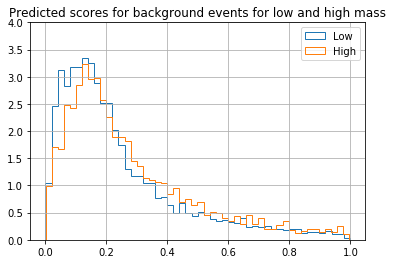

In [19]:
bkg_low = list (set( np.where(y_test==0)[0] ) & set( np.where(mass_test<mass_test.mean())[0]))
bkg_high = list (set( np.where(y_test==0)[0] ) & set( np.where(mass_test>=mass_test.mean())[0]))

plt.hist(y_pred[bkg_low], weights=weights_test[bkg_low], bins=50, histtype="step", normed=1, label="Low")
plt.hist(y_pred[bkg_high], weights=weights_test[bkg_high], bins=50, histtype="step", normed=1, label="High")

plt.title("Predicted scores for background events for low and high mass")
plt.ylim(0, 4)
plt.legend()
plt.grid()
plt.show()

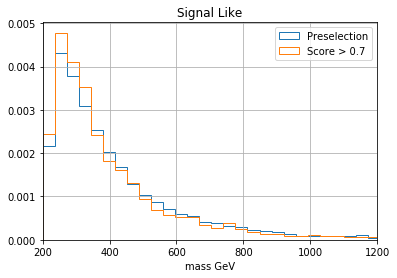

In [39]:
def getGevMass(mass):
    return np.exp (mass * (mass_max - mass_min) + mass_min)
threshold = 0.7
plt.hist(getGevMass(mass_test[y_test==1]), weights=weights_test[y_test==1], bins=50, histtype="step", normed=1, range=(200, 2000), label="Preselection")
plt.hist(getGevMass(mass_test[y_pred > threshold]), weights=weights_test[y_pred > threshold], bins=50, histtype="step", normed=1, range=(200, 2000), label="Score > " + str(threshold))

plt.title("Signal Like")
#plt.ylim(0, 4)
plt.xlim(200, 1200)
plt.xlabel("mass GeV")
plt.legend()
plt.grid()
plt.show()

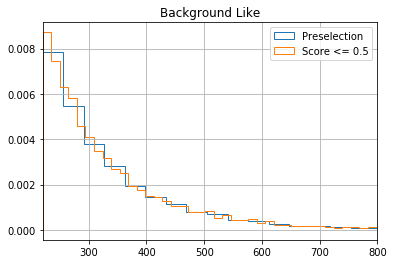

In [40]:
plt.hist(getGevMass(mass_test[y_test==0]), weights=weights_test[y_test==0], bins=50, histtype="step", normed=1, range=(220, 2000), label="Preselection")
plt.hist(getGevMass(mass_test[y_pred <= 0.5]), weights=weights_test[y_pred <= 0.5], bins=120, histtype="step", normed=1, range=(220, 2000), label="Score <= 0.5")

plt.title("Background Like")
#plt.ylim(0, 4)
plt.xlim(220,800 )
plt.legend()
plt.grid()
plt.show()

In [23]:
from scipy.stats import pearsonr
corr = pearsonr(mass_test, y_pred)
print "Unweighted correlation with mass is", corr

Unweighted correlation with mass is (0.11315686, 1.4849069923014459e-158)


In [24]:
(y_pred>0.5).sum()/float(y_pred.shape[0]) # much better than without class_weight training

0.35573617874534519

# Now with Adversarial Network

In [25]:
def make_trainable(network, flag):
    network.trainable = flag
    for l in network.layers:
        l.trainable = flag

inputs = Input(shape=(X_train.shape[1],))

Dx = Dense(32, activation="relu")(inputs)
Dx = Dense(32, activation="relu")(Dx)
Dx = Dense(32, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(input=[inputs], output=[Dx])

#@TODO: Gradient reversal layer, and simul training
#@TODO: loss on only the signal, we want that to be flat
Rx = Dx
Rx = Dense(32, activation="relu")(Rx)
Rx = Dense(32, activation="relu")(Rx)
Rx = Dense(32, activation="relu")(Rx)
#Rx = Dense(1, activation="sigmoid")(Rx) #try regression activations @TODO ask andreas !!!
Rx = Dense(1, activation="relu")(Rx)
R = Model(input=[inputs], outputs=[Rx])
#@TODO: loss only on background events, tanh activation, batch norm, drop out, see Andreas


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`
  if sys.path[0] == '':
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`


In [26]:
from keras.optimizers import SGD
from keras.losses import mean_squared_error

lam = 100.0 #10.0 # pivotal trade-off

def make_loss_D(c):
    def loss_D(y_true, y_pred):
        return c * K.binary_crossentropy(y_pred, y_true)
        #return c * K.mean (K.binary_crossentropy(y_pred, y_true))
    return loss_D

def make_loss_R(c):
    def loss_R(z_true, z_pred):
        return c * mean_squared_error(z_pred, z_true)
    return loss_R

opt_D = SGD()
D.compile(loss=[make_loss_D(c=1.0)], optimizer=opt_D)
#D.compile(loss="binary_crossentropy", optimizer=opt_D)

# Train D such that R loss (its c=-lam) is also minimised, make it invariant to R
#can we train simultaneous? grad reversal layer???
opt_DRf = SGD(momentum=0.0)
DRf = Model(input=[inputs], output=[D(inputs), R(inputs)])
make_trainable(R, False)
make_trainable(D, True)
DRf.compile(loss=[make_loss_D(c=1.0), make_loss_R(c=-lam)], optimizer=opt_DRf)

opt_DfR = SGD(momentum=0.0)
DfR = Model(input=[inputs], output=[R(inputs)])
make_trainable(R, True)
make_trainable(D, False)
DfR.compile(loss=[make_loss_R(c=1.0)], optimizer=opt_DfR)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:30: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`


In [27]:
# Pretrain D
make_trainable(R, False)
make_trainable(D, True)
D.fit(X_train, y_train, nb_epoch=15, class_weight=get_class_weights(y_train))

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Epoch 1/15
167568/167568 [==============================] - 7s - loss: 4.5085     
Epoch 2/15
167568/167568 [==============================] - 6s - loss: 4.3859     
Epoch 3/15
167568/167568 [==============================] - 7s - loss: 4.3579     
Epoch 4/15
167568/167568 [==============================] - 6s - loss: 4.3386     
Epoch 5/15
167568/167568 [==============================] - 6s - loss: 4.3560     
Epoch 6/15
167568/167568 [==============================] - 6s - loss: 4.3556     
Epoch 7/15
167568/167568 [==============================] - 6s - loss: 4.3468     
Epoch 8/15
167568/167568 [==============================] - 6s - loss: 4.3380     
Epoch 9/15
167568/167568 [==============================] - 7s - loss: 4.3406     
Epoch 10/15
167568/167568 [==============================] - 7s - loss: 4.3248     
Epoch 11/15
167568/167568 [==============================] - 7s - loss: 4.3374     
Epoch 12/15
167568/167568 [==============================] - 7s - loss: 4.3182     
E

In [28]:
# Pretrain R
make_trainable(R, True)
make_trainable(D, False)
DfR.fit(X_train, mass_train, nb_epoch=7)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Epoch 1/7
167568/167568 [==============================] - 7s - loss: 0.0292     
Epoch 2/7
167568/167568 [==============================] - 7s - loss: 0.0174     
Epoch 3/7
167568/167568 [==============================] - 7s - loss: 0.0174     
Epoch 4/7
167568/167568 [==============================] - 7s - loss: 0.0174     
Epoch 5/7
167568/167568 [==============================] - 7s - loss: 0.0174     
Epoch 6/7
167568/167568 [==============================] - 7s - loss: 0.0174     
Epoch 7/7
167568/167568 [==============================] - 7s - loss: 0.0174     


In [29]:
def plot_losses(i, losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())

    ax1 = plt.subplot(311)   
    values = np.array(losses["L_f"])
    plt.plot(range(len(values)), values, label=r"$L_f$", color="blue")
    plt.legend(loc="upper right")
    plt.grid()
    
    ax2 = plt.subplot(312, sharex=ax1) 
    values = np.array(losses["L_r"]) / lam
    plt.plot(range(len(values)), values, label=r"$L_r$", color="green")
    plt.legend(loc="upper right")
    plt.grid()
    
    ax3 = plt.subplot(313, sharex=ax1)
    values = np.array(losses["L_f - L_r"])
    plt.plot(range(len(values)), values, label=r"$L_f - \lambda L_r$", color="red")  
    plt.legend(loc="upper right")
    plt.grid()
    
    plt.show()

In [30]:
losses = {"L_f": [], "L_r": [], "L_f - L_r": []}

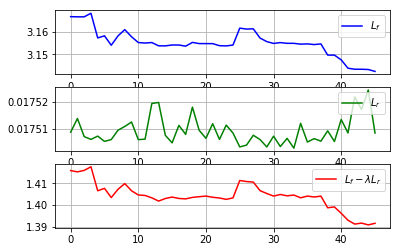

DRf
DfR
Epoch 1/1
167568/167568 [==============================] - 1s - loss: 0.0174     
(3.138393556252439, 0.0175105864965482, 1.7510586496548199)
DRf
DfR
Epoch 1/1
167568/167568 [==============================] - 1s - loss: 0.0174     
(3.1388714492204453, 0.017508562827171757, 1.7508562827171756)
DRf
DfR
Epoch 1/1
167568/167568 [==============================] - 1s - loss: 0.0174     
(3.1388633698629209, 0.017510659746234513, 1.7510659746234514)
DRf
DfR
Epoch 1/1
167568/167568 [==============================] - 1s - loss: 0.0174     
(3.1388633317883414, 0.017508338930886169, 1.7508338930886169)
DRf
DfR
Epoch 1/1
167568/167568 [==============================] - 1s - loss: 0.0174     


In [31]:
batch_size = 128
training_iterations = 50#201
for i in range(training_iterations):
    l = DRf.evaluate(X_test, [y_test, mass_test], verbose=0) #add weight!!!   
    losses["L_f - L_r"].append(l[0][None][0])
    losses["L_f"].append(l[1][None][0]) # why none, 0? just do l[1]??
    losses["L_r"].append(-l[2][None][0])
    print(losses["L_f"][-1], losses["L_r"][-1] / lam, losses["L_r"][-1])
    
    if i % 5 == 0:
        plot_losses(i, losses)

    # Fit D
    make_trainable(R, False)
    make_trainable(D, True)
    indices = np.random.permutation(len(X_train))[:batch_size]
    print "DRf"
    DRf.train_on_batch(X_train[indices], [y_train[indices], mass_train[indices]], class_weight=get_class_weights(y_train[indices]))
        
    # Fit R
    make_trainable(R, True)
    make_trainable(D, False)
    print "DfR"
    DfR.fit(X_train, mass_train, batch_size=batch_size, nb_epoch=1, verbose=1)
    #@TODO: ask andreas grand reversal layer

In [32]:
y_pred_dc = D.predict(X_test)
y_pred_dc = y_pred_dc.ravel()
roc_auc_score(y_test, y_pred_dc, sample_weight=weights_test)

0.82796977757993251

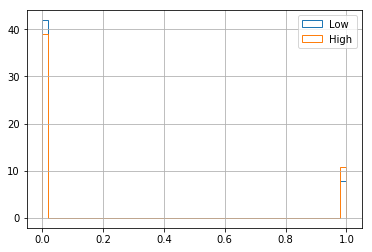

In [33]:
plt.hist(y_pred_dc[mass_test<mass_test.mean()], weights=weights_test[mass_test<mass_test.mean()], bins=50, histtype="step", normed=1, label="Low")
plt.hist(y_pred_dc[mass_test>=mass_test.mean()], weights=weights_test[mass_test>=mass_test.mean()], bins=50, histtype="step", normed=1, label="High")


#plt.ylim(0, 5)
plt.legend()
plt.grid()
plt.show()# @TODO: do sep for signal background, plot mass : full mass dist, vs after cut on bdt

In [34]:
from scipy.stats import pearsonr
corr = pearsonr(mass_test, y_pred_dc)
print "Unweighted correlation with mass is", corr

Unweighted correlation with mass is (0.08859273, 1.0269599712116625e-97)


In [35]:
y_pred_dc

array([  1.00000000e+00,   1.00000000e+00,   4.98767442e-34, ...,
         2.30862142e-38,   1.00000000e+00,   1.00000000e+00], dtype=float32)

In [36]:
time mass_predict = R.predict(X_test)

CPU times: user 883 ms, sys: 384 ms, total: 1.27 s
Wall time: 825 ms


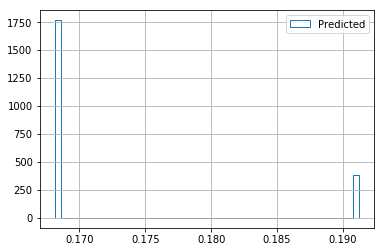

In [38]:
plt.hist(mass_predict, weights=weights_test, bins=50, histtype="step", normed=1, label="Predicted")
#plt.hist(mass_test, weights=weights_test, bins=50, histtype="step", normed=1, label="True")

#plt.ylim(0, 5)
plt.legend()
plt.grid()
plt.show()
#this is without adverserial training, notthing changes much after adverserial training ..

In [ ]:
# add real background, only makes sense to compare after adding bakground to get mass sculpting
# reweight ggF to be 1/4, qq 1/4 and vbf 1/2 for training only: create class_weight by hand 11
# crossentropy and k.crossentropy differ more than by constant, even K.mean | same for Gilles, probably not big deal
# why is the loss look decreasing further on pivot training, its not actually cuz auc is worse
# why are predictions exactly 0, 1 almost always?
# @TODO: do pivot on signal only, not background. see how Andreas did it
# loss of r is changing at a lower level, maybe subtract off the first loss? Ask Gilles,
#saw same in GAN, maybe different activation???
#just pretraining results are same as after adverserial training... even AUC is lower
#add AMS calculation to see real diff b/w adding qq and not adding qq, AUC not full pic